In [1]:
# -*- coding: utf-8 -*-
"""
Three-model pipeline on APTOS/EyePACS-style folders using EfficientNetB3.

- Model 1: Binary Low(0,1) vs High(2,3,4).
- Model 2: Binary 0 vs 1.
- Model 3: Ordinal for {2,3,4} with 2-bit targets [y>=3, y>=4].
  Mapping: 2 -> [0,0], 3 -> [1,0], 4 -> [1,1].

Training strategy (for all 3):
Stage 1: freeze EfficientNetB3 (backbone), train only head.
Stage 2: fine-tune in 3 states, unfreezing blocks progressively:
         State A: block6, block7
         State B: block4..7
         State C: block1..7
At each stage we save a .keras file and reload before the next stage.
"""

import os, gc, json, math, time, random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import cohen_kappa_score

2025-08-19 04:04:39.059501: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-19 04:04:39.080826: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755590679.109142   10555 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755590679.117463   10555 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755590679.137502   10555 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:


# ================== GPU & Seed ==================
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except Exception:
            pass

# ================== CONFIG ==================
# Thay đổi cho phù hợp dataset của bạn
TRAIN_DIR = "/home/duc/Documents/DoAn/messidor/train_preprocess"
VAL_DIR   = "/home/duc/Documents/DoAn/messidor/val_preprocess"

IMAGE_SIZE = 300 #448
BATCH_SIZE = 8

HEAD_EPOCHS = 10          # epochs cho stage 1 (train head)
FT_EPOCHS   = 10          # epochs cho mỗi state fine-tuning

LR_HEAD = 3e-4            # LR stage 1
LR_FT   = [1e-4, 5e-5, 3e-5]   # LR cho 3 state fine-tune
WEIGHT_DECAY = 1e-4

DROP_RATE   = 0.4
DENSE_UNITS = 1024

MODELS_DIR = "output_three_models_messidor"
os.makedirs(MODELS_DIR, exist_ok=True)

AUTOTUNE = tf.data.AUTOTUNE

# ================== EfficientNetB3 & Preprocess ==================
from tensorflow.keras.applications.efficientnet import EfficientNetB3, preprocess_input

# ================== Attention block (nhẹ) ==================
def sca_block(x, ratio=8, name="sca"):
    """Simple Channel Attention: GAP -> reduce(1x1) -> gate(1x1 sigmoid) -> multiply."""
    ch = int(x.shape[-1])
    mid = max(ch // ratio, 1)
    gap = layers.GlobalAveragePooling2D(keepdims=True, name=f"{name}_gap")(x)
    red = layers.Conv2D(mid, 1, padding="same", activation="relu", use_bias=True, name=f"{name}_reduce")(gap)
    gate= layers.Conv2D(ch,  1, padding="same", activation="sigmoid", use_bias=True, name=f"{name}_gate")(red)
    return layers.Multiply(name=f"{name}_mul")([x, gate])

# ================== Dataset helpers ==================
def _map_img(img, lbl):
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)
    return img, lbl

def _ds_from_dir(data_dir, class_names, shuffle, seed=SEED):
    # Chỉ lấy các class cần (class_names có thể là ["0","1","2","3","4"] hoặc ["0","1"] hay ["2","3","4"])
    ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels="inferred",
        label_mode="int",
        class_names=class_names,            # Only these classes are included
        color_mode="rgb",
        batch_size=BATCH_SIZE,
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        shuffle=shuffle,
        seed=seed
    )
    return ds


In [3]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1", threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.precision = tf.keras.metrics.Precision(thresholds=threshold)
        self.recall = tf.keras.metrics.Recall(thresholds=threshold)

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return tf.where(p + r > 0, 2.0 * p * r / (p + r), 0.0)

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


In [4]:
def enforce_monotonic_ord_np(p_ord):
    p = p_ord.copy()
    p[:, 1] = np.minimum(p[:, 1], p[:, 0])  # p_ge4 <= p_ge3
    return p

def bits_to_234_np(bits):
    out = np.full((bits.shape[0],), 3, dtype=np.int32)
    cond00 = (bits[:, 0] == 0) & (bits[:, 1] == 0)
    cond10 = (bits[:, 0] == 1) & (bits[:, 1] == 0)
    cond11 = (bits[:, 0] == 1) & (bits[:, 1] == 1)
    out[cond00] = 2
    out[cond10] = 3
    out[cond11] = 4
    return out


In [5]:
class OrdinalQWKCheckpoint(tf.keras.callbacks.Callback):
    """
    Tính QWK trên ds_val (nhãn 2-bit [y>=3, y>=4]) sau mỗi epoch.
    Lưu model vào filepath nếu QWK cải thiện.
    """
    def __init__(self, val_ds, filepath, th=0.5):
        super().__init__()
        self.val_ds = val_ds
        self.filepath = filepath
        self.th = th
        self.best = -np.inf

    def on_epoch_end(self, epoch, logs=None):
        y_true, y_pred = [], []
        for xb, yb in self.val_ds:
            # yb: (B,2) -> true labels {2,3,4}
            yb_np = yb.numpy()
            true_bits = (yb_np >= 0.5).astype(int)
            true_234 = bits_to_234_np(true_bits)

            # predict
            p = self.model.predict(xb, verbose=0)  # (B,2) [p_ge3, p_ge4]
            p = enforce_monotonic_ord_np(p)
            bits = (p >= self.th).astype(int)
            pred_234 = bits_to_234_np(bits)

            # map 2,3,4 -> 0,1,2 để tính kappa ổn định
            y_true.append(true_234 - 2)
            y_pred.append(pred_234 - 2)

        y_true = np.concatenate(y_true, axis=0)
        y_pred = np.concatenate(y_pred, axis=0)

        qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
        if logs is not None:
            logs["val_qwk"] = qwk  # để hiển thị trong log

        if qwk > self.best:
            self.best = qwk
            self.model.save(self.filepath)
        print(f"\nEpoch {epoch+1}: val_qwk={qwk:.4f} (best={self.best:.4f})")


In [3]:

# -------- Model 1: Low(0,1) vs High(2,3,4) --------
def map_label_low_high(label_int):
    # label_int in {0,1,2,3,4} -> 0 if in {0,1}, else 1
    y = tf.where(label_int <= 1, 0, 1)
    y = tf.cast(y, tf.float32)
    return y

def map_preprocess_m1(img, lbl):
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)
    y = map_label_low_high(lbl)
    y = tf.expand_dims(y, axis=-1)  # (B,1) sigmoid
    return img, y

def make_ds_m1(train_dir, val_dir):
    class_names = ["0","1","2","3","4"]
    ds_tr = _ds_from_dir(train_dir, class_names, shuffle=True).map(map_preprocess_m1, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    ds_va = _ds_from_dir(val_dir,   class_names, shuffle=False).map(map_preprocess_m1, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    return ds_tr, ds_va

# -------- Model 2: Binary 0 vs 1 --------
def map_preprocess_m2(img, lbl):
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)
    y = tf.cast(lbl, tf.float32)      # lbl ∈ {0,1}
    y = tf.expand_dims(y, axis=-1)    # (B,1) sigmoid
    return img, y

def make_ds_m2(train_dir, val_dir):
    class_names = ["0","1"]  # chỉ lấy hai lớp này, tự động bỏ qua 2,3,4 nếu có
    ds_tr = _ds_from_dir(train_dir, class_names, shuffle=True).map(map_preprocess_m2, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    ds_va = _ds_from_dir(val_dir,   class_names, shuffle=False).map(map_preprocess_m2, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    return ds_tr, ds_va

# -------- Model 3: Ordinal for {2,3,4} with 2-bit [y>=3, y>=4] --------
def ordinal_encode_234(label_idx):
    """
    label_idx is index over class_names=["2","3","4"], i.e. values in {0,1,2}
    We need two bits: [y>=3, y>=4] which is equivalent to [label_idx>=1, label_idx>=2].
    2 -> 0 -> [0,0]
    3 -> 1 -> [1,0]
    4 -> 2 -> [1,1]
    """
    t1 = tf.cast(label_idx >= 1, tf.float32)
    t2 = tf.cast(label_idx >= 2, tf.float32)
    y = tf.stack([t1, t2], axis=-1)  # (B,2)
    return y

def map_preprocess_m3(img, lbl_idx):
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)
    y = ordinal_encode_234(lbl_idx)
    return img, y

def make_ds_m3(train_dir, val_dir):
    class_names = ["2","3","4"]
    ds_tr = _ds_from_dir(train_dir, class_names, shuffle=True).map(map_preprocess_m3, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    ds_va = _ds_from_dir(val_dir,   class_names, shuffle=False).map(map_preprocess_m3, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    return ds_tr, ds_va

# ================== Model builders ==================
def build_backbone_b3(inputs, freeze=True):
    base = EfficientNetB3(include_top=False, weights="imagenet", input_tensor=inputs)
    base.trainable = not freeze
    return base

def build_head(x, drop=DROP_RATE, units=DENSE_UNITS, name_prefix="head"):
    x = sca_block(x, ratio=8, name=f"{name_prefix}_sca")
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(drop)(x)
    x = layers.Dense(units, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(drop * 0.75)(x)
    return x

# ---- Model 1: binary Low vs High (sigmoid 1 unit) ----
def build_model_1(img_size=IMAGE_SIZE, freeze_backbone=True):
    inputs = layers.Input(shape=(img_size, img_size, 3))
    base = build_backbone_b3(inputs, freeze=freeze_backbone)
    x = build_head(base.output, name_prefix="m1")
    out = layers.Dense(1, activation="sigmoid", name="bin")(x)
    return models.Model(inputs, out, name="EffB3_M1_LowHigh")

# ---- Model 2: binary 0 vs 1 (sigmoid 1 unit) ----
def build_model_2(img_size=IMAGE_SIZE, freeze_backbone=True):
    inputs = layers.Input(shape=(img_size, img_size, 3))
    base = build_backbone_b3(inputs, freeze=freeze_backbone)
    x = build_head(base.output, name_prefix="m2")
    out = layers.Dense(1, activation="sigmoid", name="bin")(x)
    return models.Model(inputs, out, name="EffB3_M2_0vs1")

# ---- Model 3: ordinal for 2,3,4 → 2-bit sigmoid [y>=3, y>=4] ----
def build_model_3(img_size=IMAGE_SIZE, freeze_backbone=True):
    inputs = layers.Input(shape=(img_size, img_size, 3))
    base = build_backbone_b3(inputs, freeze=freeze_backbone)
    x = build_head(base.output, name_prefix="m3")
    out = layers.Dense(2, activation="sigmoid", name="ord2")(x)
    return models.Model(inputs, out, name="EffB3_M3_234Ordinal")

# ================== Compile helpers ==================
def compile_binary(model, lr, wd=WEIGHT_DECAY):
    try:
        opt = tf.keras.optimizers.AdamW(learning_rate=lr, weight_decay=wd)
    except Exception:
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=opt,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=[tf.keras.metrics.BinaryAccuracy(name="acc"), tf.keras.metrics.AUC(name="auc")]
    )
    return model

def compile_multi_sigmoid(model, lr, wd=WEIGHT_DECAY):
    # For model 3: 2 independent sigmoids (multi-label BCE)
    try:
        opt = tf.keras.optimizers.AdamW(learning_rate=lr, weight_decay=wd)
    except Exception:
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=opt,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=[tf.keras.metrics.AUC(name="auc", multi_label=True)]
    )
    return model

# ================== Fine-tune utilities ==================
def set_trainable_blocks(model, prefixes_to_unfreeze):
    """
    Unfreeze all layers whose names start with any prefix in prefixes_to_unfreeze.
    Keep BatchNormalization layers frozen to avoid instability.
    """
    for layer in model.layers:
        name = getattr(layer, "name", "")
        if any(name.startswith(pfx) for pfx in prefixes_to_unfreeze):
            layer.trainable = True
        # Freeze all BN layers
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False

def run_stage_training(model, ds_train, ds_val, epochs, lr, ckpt_path, is_binary=True):
    # Recompile per stage with updated LR
    if is_binary:
        compile_binary(model, lr)
    else:
        compile_multi_sigmoid(model, lr)

    cbs = [
        tf.keras.callbacks.EarlyStopping(monitor="val_auc", patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_auc", factor=0.5, patience=3, min_lr=1e-6),
        tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_auc", save_best_only=True)
    ]
    history = model.fit(ds_train, validation_data=ds_val, epochs=epochs, callbacks=cbs, verbose=1)
    # Save final snapshot (optional, but we already save best via ModelCheckpoint)
    model.save(ckpt_path)
    return history

def staged_finetune_pipeline(model_name_prefix,
                             build_fn,
                             ds_train,
                             ds_val,
                             is_binary,
                             head_epochs=HEAD_EPOCHS,
                             ft_epochs=FT_EPOCHS,
                             lr_head=LR_HEAD,
                             lr_stages=LR_FT):
    """
    Generic 4-stage pipeline:
      Stage 1: Train head (frozen backbone)
      Stage 2: unfreeze block6..7
      Stage 3: unfreeze block4..7
      Stage 4: unfreeze block1..7
    """
    # -------- Stage 1 --------
    s1_path = os.path.join(MODELS_DIR, f"{model_name_prefix}_stage1.keras")
    if os.path.exists(s1_path):
        print(f"[{model_name_prefix}] Found Stage1 checkpoint, loading:", s1_path)
        model = tf.keras.models.load_model(s1_path, compile=False)
    else:
        print(f"\n[{model_name_prefix}] === Stage 1: Train head (backbone frozen) ===")
        model = build_fn(freeze_backbone=True)
        if is_binary:
            compile_binary(model, lr_head)
        else:
            compile_multi_sigmoid(model, lr_head)
        run_stage_training(model, ds_train, ds_val, head_epochs, lr_head, s1_path, is_binary=is_binary)

    # -------- Stage 2~4 (fine-tuning) --------
    stage_blocks = [
        ["block6", "block7"],
        ["block4", "block5", "block6", "block7"],
        ["block1", "block2", "block3", "block4", "block5", "block6", "block7"],
    ]
    for idx, (prefixes, lr) in enumerate(zip(stage_blocks, lr_stages), start=2):
        ck = os.path.join(MODELS_DIR, f"{model_name_prefix}_stage{idx}.keras")
        if os.path.exists(ck):
            print(f"[{model_name_prefix}] Found Stage{idx} checkpoint, loading:", ck)
            continue
        # Always reload previous best to reduce memory usage and ensure good init
        prev = os.path.join(MODELS_DIR, f"{model_name_prefix}_stage{idx-1}.keras")
        print(f"\n[{model_name_prefix}] === Stage {idx}: Unfreeze {prefixes} ===")
        model = tf.keras.models.load_model(prev, compile=False)
        set_trainable_blocks(model, prefixes)
        # Keep head layers trainable by default (already True)
        run_stage_training(model, ds_train, ds_val, ft_epochs, lr, ck, is_binary=is_binary)

    print(f"\n[{model_name_prefix}] === Completed all stages ===")



In [4]:
# ================== MAIN ==================

    # -------- Datasets for each model --------
tf.keras.backend.clear_session(); gc.collect()
print("Preparing datasets...")
ds1_train, ds1_val = make_ds_m1(TRAIN_DIR, VAL_DIR)   # Low vs High
ds2_train, ds2_val = make_ds_m2(TRAIN_DIR, VAL_DIR)   # 0 vs 1
ds3_train, ds3_val = make_ds_m3(TRAIN_DIR, VAL_DIR)   # 2/3/4 ordinal 2-bit





Preparing datasets...
Found 4163 files belonging to 5 classes.


I0000 00:00:1755590690.916996   10555 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2281 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 174 files belonging to 5 classes.
Found 1677 files belonging to 2 classes.
Found 129 files belonging to 2 classes.
Found 2486 files belonging to 3 classes.
Found 45 files belonging to 3 classes.


In [8]:
    # -------- Model 1 pipeline --------
tf.keras.backend.clear_session(); gc.collect()
staged_finetune_pipeline(
        model_name_prefix="effb3_low_high",
        build_fn=lambda freeze_backbone=True: build_model_1(IMAGE_SIZE, freeze_backbone),
        ds_train=ds1_train,
        ds_val=ds1_val,
        is_binary=True,
        head_epochs=HEAD_EPOCHS,
        ft_epochs=FT_EPOCHS,
        lr_head=LR_HEAD,
        lr_stages=LR_FT
    )


[effb3_low_high] Found Stage1 checkpoint, loading: output_three_models_messidor/effb3_low_high_stage1.keras
[effb3_low_high] Found Stage2 checkpoint, loading: output_three_models_messidor/effb3_low_high_stage2.keras
[effb3_low_high] Found Stage3 checkpoint, loading: output_three_models_messidor/effb3_low_high_stage3.keras
[effb3_low_high] Found Stage4 checkpoint, loading: output_three_models_messidor/effb3_low_high_stage4.keras

[effb3_low_high] === Completed all stages ===


In [9]:
    # -------- Model 2 pipeline --------
tf.keras.backend.clear_session(); gc.collect()
staged_finetune_pipeline(
        model_name_prefix="effb3_0_vs_1",
        build_fn=lambda freeze_backbone=True: build_model_2(IMAGE_SIZE, freeze_backbone),
        ds_train=ds2_train,
        ds_val=ds2_val,
        is_binary=True,
        head_epochs=HEAD_EPOCHS,
        ft_epochs=FT_EPOCHS,
        lr_head=LR_HEAD,
        lr_stages=LR_FT
    )



[effb3_0_vs_1] Found Stage1 checkpoint, loading: output_three_models_messidor/effb3_0_vs_1_stage1.keras
[effb3_0_vs_1] Found Stage2 checkpoint, loading: output_three_models_messidor/effb3_0_vs_1_stage2.keras
[effb3_0_vs_1] Found Stage3 checkpoint, loading: output_three_models_messidor/effb3_0_vs_1_stage3.keras

[effb3_0_vs_1] === Stage 4: Unfreeze ['block1', 'block2', 'block3', 'block4', 'block5', 'block6', 'block7'] ===
Epoch 1/10


I0000 00:00:1755589064.630244    8069 service.cc:152] XLA service 0x7f4b4c003e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755589064.630297    8069 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-08-19 03:37:45.470484: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755589069.255327    8069 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1755589103.329182    8069 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-08-19 03:38:23.351947: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:382] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this messa

210/210 ━━━━━━━━━━━━━━━━━━━━ 133s 363ms/step - acc: 0.9240 - auc: 0.9835 - loss: 0.1628 - val_acc: 0.7597 - val_auc: 0.7407 - val_loss: 0.7008 - learning_rate: 3.0000e-05
Epoch 2/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 24s 113ms/step - acc: 0.9380 - auc: 0.9847 - loss: 0.1529 - val_acc: 0.7287 - val_auc: 0.7821 - val_loss: 0.6290 - learning_rate: 3.0000e-05
Epoch 3/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 25s 120ms/step - acc: 0.9695 - auc: 0.9959 - loss: 0.0756 - val_acc: 0.7752 - val_auc: 0.7110 - val_loss: 0.8324 - learning_rate: 3.0000e-05
Epoch 4/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 24s 114ms/step - acc: 0.9808 - auc: 0.9983 - loss: 0.0462 - val_acc: 0.7829 - val_auc: 0.7498 - val_loss: 0.7272 - learning_rate: 3.0000e-05
Epoch 5/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 25s 119ms/step - acc: 0.9853 - auc: 0.9990 - loss: 0.0387 - val_acc: 0.8062 - val_auc: 0.6046 - val_loss: 1.3265 - learning_rate: 3.0000e-05
Epoch 6/10
210/210 ━━━━━━━━━━━━━━━━━━━━ 24s 114ms/step - acc: 0.9740 - auc: 0.9978 - loss: 0.0668 - val_a

In [5]:
    # -------- Model 3 pipeline --------
tf.keras.backend.clear_session(); gc.collect()
staged_finetune_pipeline(
        model_name_prefix="effb3_234_ordinal2bit",
        build_fn=lambda freeze_backbone=True: build_model_3(IMAGE_SIZE, freeze_backbone),
        ds_train=ds3_train,
        ds_val=ds3_val,
        is_binary=False,   # multi-label BCE for 2-bit ordinal
        head_epochs=HEAD_EPOCHS,
        ft_epochs=FT_EPOCHS,
        lr_head=LR_HEAD,
        lr_stages=LR_FT
    )

print("\nAll three pipelines finished.")

[effb3_234_ordinal2bit] Found Stage1 checkpoint, loading: output_three_models_messidor/effb3_234_ordinal2bit_stage1.keras
[effb3_234_ordinal2bit] Found Stage2 checkpoint, loading: output_three_models_messidor/effb3_234_ordinal2bit_stage2.keras
[effb3_234_ordinal2bit] Found Stage3 checkpoint, loading: output_three_models_messidor/effb3_234_ordinal2bit_stage3.keras

[effb3_234_ordinal2bit] === Stage 4: Unfreeze ['block1', 'block2', 'block3', 'block4', 'block5', 'block6', 'block7'] ===
Epoch 1/10


I0000 00:00:1755590717.569709   10701 service.cc:152] XLA service 0x7d14e0013a20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755590717.569739   10701 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-08-19 04:05:18.487009: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755590722.243321   10701 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1755590757.278325   10701 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-08-19 04:05:57.303254: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:382] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this messa

311/311 ━━━━━━━━━━━━━━━━━━━━ 146s 285ms/step - auc: 0.9996 - loss: 0.0182 - val_auc: 0.9101 - val_loss: 0.2489 - learning_rate: 3.0000e-05
Epoch 2/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 34s 110ms/step - auc: 0.9995 - loss: 0.0104 - val_auc: 0.9121 - val_loss: 0.3294 - learning_rate: 3.0000e-05
Epoch 3/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 36s 114ms/step - auc: 0.9998 - loss: 0.0151 - val_auc: 0.9099 - val_loss: 0.2499 - learning_rate: 3.0000e-05
Epoch 4/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 36s 115ms/step - auc: 0.9998 - loss: 0.0062 - val_auc: 0.9094 - val_loss: 0.3122 - learning_rate: 3.0000e-05
Epoch 5/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 36s 115ms/step - auc: 0.9999 - loss: 0.0028 - val_auc: 0.9068 - val_loss: 0.3319 - learning_rate: 3.0000e-05
Epoch 6/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 36s 115ms/step - auc: 0.9995 - loss: 0.0128 - val_auc: 0.8223 - val_loss: 0.6727 - learning_rate: 3.0000e-05
Epoch 7/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 35s 112ms/step - auc: 0.9983 - loss: 0.0023 - val_auc: 0.9037 - val_loss: 0.

Loading models...

=== Model 1: Low(0,1) vs High(2,3,4) ===
              precision    recall  f1-score   support

    Low(0,1)     0.9021    1.0000    0.9485       129
 High(2,3,4)     1.0000    0.6957    0.8205        46

    accuracy                         0.9200       175
   macro avg     0.9510    0.8478    0.8845       175
weighted avg     0.9278    0.9200    0.9149       175



2025-08-19 04:18:05.665199: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


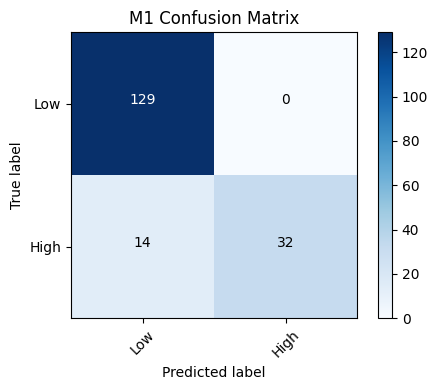


=== Model 2: 0 vs 1 ===
              precision    recall  f1-score   support

           0     0.8318    0.8725    0.8517       102
           1     0.4091    0.3333    0.3673        27

    accuracy                         0.7597       129
   macro avg     0.6204    0.6029    0.6095       129
weighted avg     0.7433    0.7597    0.7503       129



2025-08-19 04:18:21.651473: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


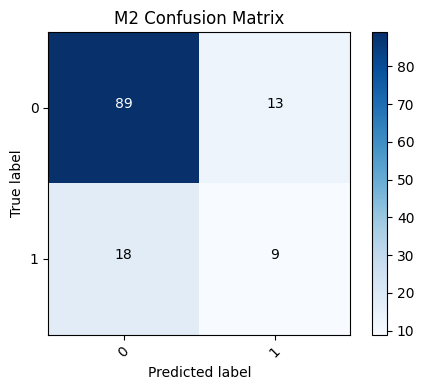


=== Model 3: 2/3/4 (ordinal 2-bit) ===
              precision    recall  f1-score   support

           2     0.8462    0.9429    0.8919        35
           3     0.5000    0.3750    0.4286         8
           4     1.0000    0.3333    0.5000         3

    accuracy                         0.8043        46
   macro avg     0.7821    0.5504    0.6068        46
weighted avg     0.7960    0.8043    0.7858        46



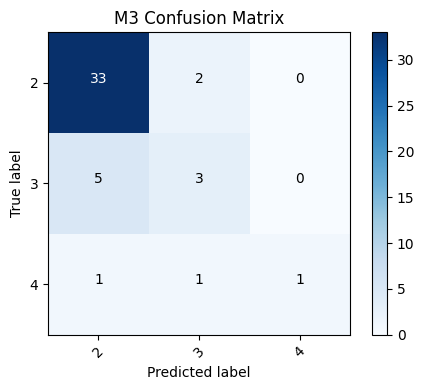


=== Unified system: 0..4 ===
              precision    recall  f1-score   support

           0     0.7807    0.8725    0.8241       102
           1     0.3103    0.3333    0.3214        27
           2     0.7600    0.5429    0.6333        35
           3     0.5000    0.3750    0.4286         8
           4     1.0000    0.3333    0.5000         3

    accuracy                         0.6914       175
   macro avg     0.6702    0.4914    0.5415       175
weighted avg     0.6949    0.6914    0.6847       175



2025-08-19 04:19:32.023017: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


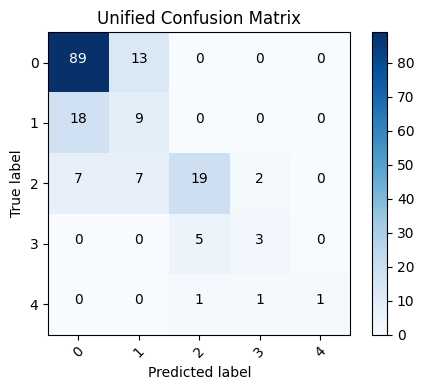


Done.


In [6]:
# -*- coding: utf-8 -*-
"""
Evaluation + Unified Prediction for 3 EfficientNetB3 models.

- Model 1: Low(0,1) vs High(2,3,4)      -> sigmoid(1)
- Model 2: 0 vs 1                        -> sigmoid(1)
- Model 3: Ordinal for {2,3,4}: [y>=3, y>=4] -> sigmoid(2)
Mapping ordinal: 2->[0,0], 3->[1,0], 4->[1,1]

This script:
1) Đánh giá từng model với classification report + confusion matrix.
2) Dự đoán hợp nhất (fuse) -> nhãn cuối 0..4 và đánh giá tổng thể.

Yêu cầu:
- Đã train xong các model và lưu .keras như trong tên file dưới.
- Thư mục VAL_DIR/TEST_DIR theo cấu trúc Keras: root/(0|1|2|3|4)/*.jpg
"""

import os, gc, random, numpy as np
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ============== CONFIG ==============
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Đổi sang TEST_DIR nếu muốn đánh giá trên test
ROOT_DIR = "/home/duc/Documents/DoAn/messidor/test_preprocess"

IMAGE_SIZE = 300
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

# Đường dẫn model cuối cùng (đã fine-tune xong)
M1_PATH = "output_three_models_messidor/effb3_low_high_stage4.keras"
M2_PATH = "output_three_models_messidor/effb3_0_vs_1_stage4.keras"
M3_PATH = "output_three_models_messidor/effb3_234_ordinal2bit_stage4.keras"

# Ngưỡng
TH_BIN = 0.5   # cho sigmoid nhị phân (M1/M2)
TH_ORD = 0.5   # cho 2-bit ordinal (M3)

# ============== GPU ==============
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for g in gpus:
        try:
            tf.config.experimental.set_memory_growth(g, True)
        except Exception:
            pass

# ============== Data helpers ==============
CLASS_NAMES = ["0","1","2","3","4"]
CLASS_TO_INT = {c:i for i,c in enumerate(CLASS_NAMES)}  # "0"->0, ..., "4"->4

def list_images_with_labels(root, class_names=CLASS_NAMES):
    paths, labels = [], []
    for c in class_names:
        cdir = os.path.join(root, c)
        if not os.path.isdir(cdir):
            continue
        for fname in os.listdir(cdir):
            if fname.lower().endswith((".jpg",".jpeg",".png",".bmp",".tiff",".webp")):
                paths.append(os.path.join(cdir, fname))
                labels.append(int(c))
    return paths, np.array(labels, dtype=np.int32)

def _read_resize_preprocess(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE), method="bicubic")
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)
    return img

def make_dataset(root, batch_size=BATCH_SIZE, shuffle=False):
    paths, labels = list_images_with_labels(root, CLASS_NAMES)
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), seed=SEED, reshuffle_each_iteration=False)
    def _map(path, y):
        img = _read_resize_preprocess(path)
        return img, y
    ds = ds.map(_map, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)
    return ds, paths, labels

# ============== Utility: plots & printing ==============
def plot_confusion_matrix(cm, labels, title="Confusion Matrix"):
    fig = plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    thresh = cm.max() / 2.0 if cm.size else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def enforce_monotonic_ord(p_ord):
    """
    Ensure p(y>=4) <= p(y>=3) for ordinal outputs.
    p_ord: (N,2) -> [:,0]=p_ge3, [:,1]=p_ge4
    """
    p = p_ord.copy()
    p[:,1] = np.minimum(p[:,1], p[:,0])
    return p

def bits_to_234(bits):
    """
    bits: (N,2), each in {0,1}, [b_ge3, b_ge4]
    Decode to {2,3,4}:
      [0,0] -> 2
      [1,0] -> 3
      [1,1] -> 4
      [0,1] (invalid) -> fix to 3
    """
    out = np.full((bits.shape[0],), 3, dtype=np.int32)
    cond00 = (bits[:,0]==0) & (bits[:,1]==0)
    cond10 = (bits[:,0]==1) & (bits[:,1]==0)
    cond11 = (bits[:,0]==1) & (bits[:,1]==1)
    out[cond00] = 2
    out[cond10] = 3
    out[cond11] = 4
    return out

# ============== Load models ==============
def load_model_safely(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Model not found: {path}")
    return tf.keras.models.load_model(path, compile=False)

# ============== Evaluate Model 1: Low vs High ==============
def evaluate_model1(ds, y_true_0to4, m1, th=TH_BIN):
    # y_true_bin: 0 (low {0,1}), 1 (high {2,3,4})
    y_true_bin = (y_true_0to4 >= 2).astype(np.int32)
    y_pred_prob = []
    for xb, _ in ds:
        p = m1.predict(xb, verbose=0)
        y_pred_prob.append(p.ravel())
    y_pred_prob = np.concatenate(y_pred_prob, axis=0)
    y_pred = (y_pred_prob >= th).astype(np.int32)

    print("\n=== Model 1: Low(0,1) vs High(2,3,4) ===")
    print(classification_report(y_true_bin, y_pred, target_names=["Low(0,1)","High(2,3,4)"], digits=4))
    cm = confusion_matrix(y_true_bin, y_pred, labels=[0,1])
    plot_confusion_matrix(cm, labels=["Low","High"], title="M1 Confusion Matrix")
    return y_pred, y_pred_prob

# ============== Evaluate Model 2: 0 vs 1 ==============
def evaluate_model2(root_dir, m2, th=TH_BIN):
    # chỉ dùng lớp 0 và 1
    ds01, _, y_true01 = make_dataset(root_dir, shuffle=False)
    # lọc chỉ 0,1 ở y_true
    # (make_dataset đã lấy đủ 0..4; ta chỉ dựa vào root_dir có đủ 0,1)
    mask = (y_true01 <= 1)
    if not np.any(mask):
        print("\n[WARNING] Không tìm thấy lớp 0/1 trong thư mục để đánh giá M2.")
        return None, None, None
    # để đơn giản, tạo lại ds chỉ chứa 0/1
    paths_all, labels_all = list_images_with_labels(root_dir, CLASS_NAMES)
    paths01 = [p for p,l in zip(paths_all, labels_all) if l in (0,1)]
    y_true01 = np.array([l for l in labels_all if l in (0,1)], dtype=np.int32)

    # build ds 0/1 riêng
    def gen01():
        for p in paths01:
            yield p
    ds_paths = tf.data.Dataset.from_generator(gen01, output_signature=tf.TensorSpec(shape=(), dtype=tf.string))
    ds_img = ds_paths.map(lambda p: (_read_resize_preprocess(p)), num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

    y_pred_prob = []
    for xb in ds_img:
        p = m2.predict(xb, verbose=0)
        y_pred_prob.append(p.ravel())
    y_pred_prob = np.concatenate(y_pred_prob, axis=0)
    y_pred = (y_pred_prob >= th).astype(np.int32)

    print("\n=== Model 2: 0 vs 1 ===")
    print(classification_report(y_true01, y_pred, target_names=["0","1"], digits=4))
    cm = confusion_matrix(y_true01, y_pred, labels=[0,1])
    plot_confusion_matrix(cm, labels=["0","1"], title="M2 Confusion Matrix")
    return y_true01, y_pred, y_pred_prob

# ============== Evaluate Model 3: 2/3/4 ordinal ==============
def evaluate_model3(root_dir, m3, th=TH_ORD):
    # chỉ dùng lớp 2,3,4
    paths_all, labels_all = list_images_with_labels(root_dir, CLASS_NAMES)
    mask = np.isin(labels_all, [2,3,4])
    if not np.any(mask):
        print("\n[WARNING] Không tìm thấy lớp 2/3/4 trong thư mục để đánh giá M3.")
        return None, None, None
    paths234 = [p for p,l in zip(paths_all, labels_all) if l in (2,3,4)]
    y_true234 = np.array([l for l in labels_all if l in (2,3,4)], dtype=np.int32)

    def gen234():
        for p in paths234:
            yield p
    ds_paths = tf.data.Dataset.from_generator(gen234, output_signature=tf.TensorSpec(shape=(), dtype=tf.string))
    ds_img = ds_paths.map(lambda p: (_read_resize_preprocess(p)), num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

    proba = []
    for xb in ds_img:
        p = m3.predict(xb, verbose=0)  # (B,2) [p_ge3, p_ge4]
        proba.append(p)
    proba = np.concatenate(proba, axis=0)
    proba = enforce_monotonic_ord(proba)
    bits = (proba >= th).astype(np.int32)
    y_pred234 = bits_to_234(bits)

    print("\n=== Model 3: 2/3/4 (ordinal 2-bit) ===")
    # classification_report với labels [2,3,4]
    print(classification_report(y_true234, y_pred234, labels=[2,3,4], target_names=["2","3","4"], digits=4))
    cm = confusion_matrix(y_true234, y_pred234, labels=[2,3,4])
    plot_confusion_matrix(cm, labels=["2","3","4"], title="M3 Confusion Matrix")
    return y_true234, y_pred234, proba

# ============== Unified prediction (0..4) ==============
def unified_predict_and_eval(root_dir, m1, m2, m3, th_bin=TH_BIN, th_ord=TH_ORD):
    ds, paths, y_true = make_dataset(root_dir, shuffle=False)
    y_pred_all = []

    for xb, yb in ds:
        # 1) Low/High by M1: p_high
        p_high = m1.predict(xb, verbose=0).ravel()
        is_high = (p_high >= th_bin)

        # 2) Route low -> M2 ; high -> M3
        # Low subset
        x_low = xb[~is_high]
        # High subset
        x_high = xb[is_high]

        # Prepare container for this batch
        y_pred_batch = np.empty((xb.shape[0],), dtype=np.int32)

        # Low -> 0/1
        if x_low.shape[0] > 0:
            p01 = m2.predict(x_low, verbose=0).ravel()
            y01 = (p01 >= th_bin).astype(np.int32)  # 0 or 1
            y_pred_batch[~is_high] = y01

        # High -> 2/3/4 via ordinal
        if x_high.shape[0] > 0:
            p_ord = m3.predict(x_high, verbose=0)  # (n_high,2)
            p_ord = enforce_monotonic_ord(p_ord)
            bits = (p_ord >= th_ord).astype(np.int32)
            y234 = bits_to_234(bits)
            y_pred_batch[is_high] = y234

        y_pred_all.append(y_pred_batch)

    y_pred_all = np.concatenate(y_pred_all, axis=0)

    print("\n=== Unified system: 0..4 ===")
    print(classification_report(y_true, y_pred_all, labels=[0,1,2,3,4], target_names=["0","1","2","3","4"], digits=4))
    cm = confusion_matrix(y_true, y_pred_all, labels=[0,1,2,3,4])
    plot_confusion_matrix(cm, labels=["0","1","2","3","4"], title="Unified Confusion Matrix")

    return paths, y_true, y_pred_all

# ============== MAIN ==============
if __name__ == "__main__":
    tf.keras.backend.clear_session(); gc.collect()

    # Load models
    print("Loading models...")
    m1 = load_model_safely(M1_PATH)  # Low/High
    m2 = load_model_safely(M2_PATH)  # 0 vs 1
    m3 = load_model_safely(M3_PATH)  # 2/3/4 ordinal

    # Evaluate M1 on full folder (0..4)
    ds_full, paths_full, y_full = make_dataset(ROOT_DIR, shuffle=False)
    _m1_pred, _m1_prob = evaluate_model1(ds_full, y_full, m1, th=TH_BIN)

    # Evaluate M2 on 0/1 subset (if available)
    evaluate_model2(ROOT_DIR, m2, th=TH_BIN)

    # Evaluate M3 on 2/3/4 subset (if available)
    evaluate_model3(ROOT_DIR, m3, th=TH_ORD)

    # Unified evaluation on full folder (0..4)
    unified_predict_and_eval(ROOT_DIR, m1, m2, m3, th_bin=TH_BIN, th_ord=TH_ORD)

    print("\nDone.")
